In [13]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import datetime
# Rozłożyć daty z 2 lat na zbiór testowy i treningowy, dodać cechy tygodnia, miesiąca, sezonu --> fastai tabular model
#cechy istnienia wyprzedaży czy nie.
df = pd.read_csv("predykcja.csv", sep=';')
df = df[-df.DATA.isna()]
df.DATA = pd.to_datetime(df['DATA'], format="%d.%m.%Y")
df.wyprzedaż = df.wyprzedaż.fillna(0).astype(int)
df.head()

,DATA,zamowienia,wyprzedaż
0,2018-01-01,100.0,0
1,2018-01-02,94.0,0
2,2018-01-03,118.0,1
3,2018-01-04,114.0,1
4,2018-01-05,122.0,1


In [33]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import math
from sklearn.metrics import mean_squared_error
import numpy as np
from fbprophet import Prophet
import pandas as pd

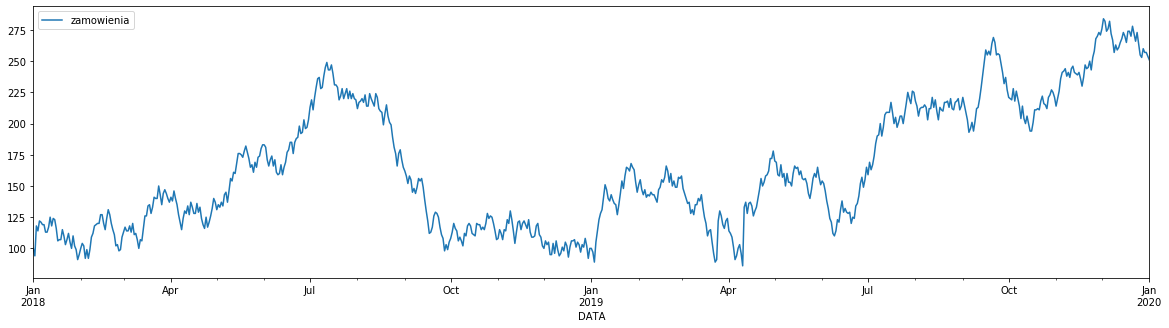

In [36]:
df.plot(x='DATA', y='zamowienia', figsize=(20,5))

In [3]:
def check_normality(data):
    from scipy import stats
    shapiro_test = stats.shapiro(data)
    return shapiro_test

In [4]:
check_normality(df.zamowienia.values)

(0.9298370480537415, 5.320810338925911e-18)

In [5]:
check_normality(np.log(df.zamowienia.values))

(0.955295205116272, 4.162683788161772e-14)

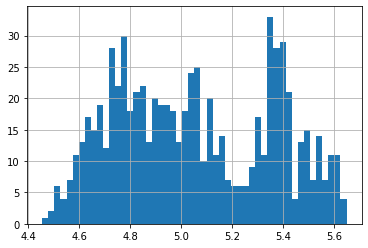

In [6]:
np.log(df.zamowienia).hist(bins=50)

In [2]:
def create_date_window(in_date, window_size):
    date_upper = pd.to_datetime(in_date) + pd.DateOffset(days=window_size)
    date_upper = date_upper.strftime('%Y-%m-%d')
    return date_upper
create_date_window('2020-01-01', 1)

'2020-01-02'

In [3]:
ranges = [f'2020-02-0{i}' for i in range(1,8)]
while True:
    df_new = pd.DataFrame([[0,0,0]], columns=['DATA', 'wyprzedaż', 'zamowienia'])
    df = df.append(df_new, ignore_index = True)
    df.iloc[df.shape[0]-1,0] = create_date_window(df.iloc[df.shape[0]-2,0], 1)
    if any(df.iloc[df.shape[0]-1,0] == r for r in ranges):
        df.iloc[df.shape[0]-1,1] = 1    
    if df.iloc[df.shape[0]-2,0] == '2020-03-01':
        break
df.tail()

,DATA,zamowienia,wyprzedaż
787,2020-02-27,0.0,0
788,2020-02-28,0.0,0
789,2020-02-29,0.0,0
790,2020-03-01,0.0,0
791,2020-03-02,0.0,0


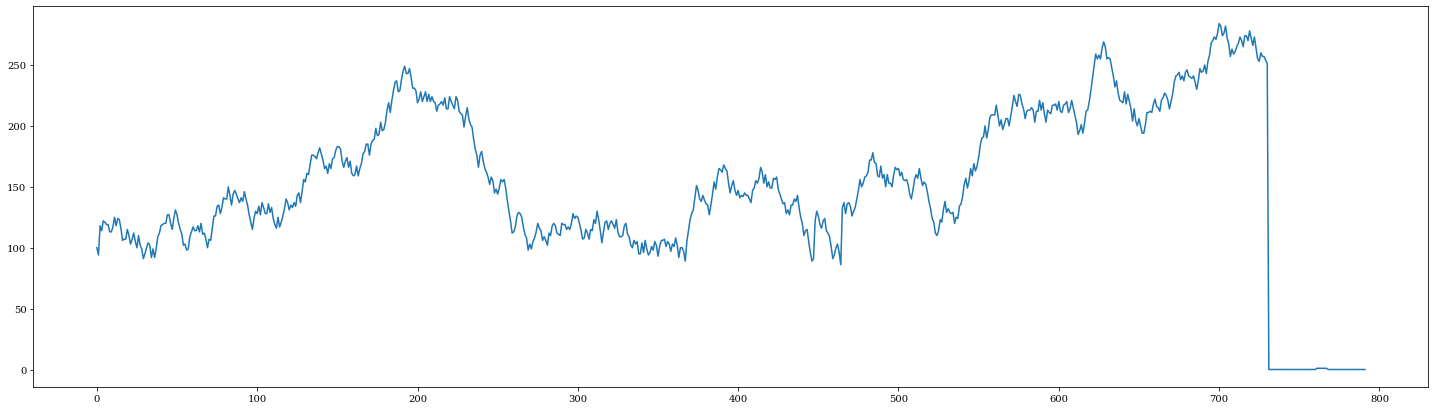

In [4]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] =  'black'
plt.rcParams['xtick.color'] =  'black'
plt.rcParams['ytick.color'] =  'black'
fig = plt.figure(figsize=(25,7))
df.zamowienia.plot()

In [6]:
def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)
        
add_datepart(df, "DATA", drop=False)
df.zamowienia = df.zamowienia.astype('float')
df.head()

/home/marzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':


,DATA,zamowienia,wyprzedaż,DATAYear,DATAMonth,DATAWeek,DATADay,DATADayofweek,DATADayofyear,DATAIs_month_end,DATAIs_month_start,DATAIs_quarter_end,DATAIs_quarter_start,DATAIs_year_end,DATAIs_year_start,DATAElapsed
0,2018-01-01,100.0,0,2018,1,1,1,0,1,False,True,False,True,False,True,1514764800
1,2018-01-02,94.0,0,2018,1,1,2,1,2,False,False,False,False,False,False,1514851200
2,2018-01-03,118.0,1,2018,1,1,3,2,3,False,False,False,False,False,False,1514937600
3,2018-01-04,114.0,1,2018,1,1,4,3,4,False,False,False,False,False,False,1515024000
4,2018-01-05,122.0,1,2018,1,1,5,4,5,False,False,False,False,False,False,1515110400


In [7]:
df.head()

,DATA,zamowienia,wyprzedaż,DATAYear,DATAMonth,DATAWeek,DATADay,DATADayofweek,DATADayofyear,DATAIs_month_end,DATAIs_month_start,DATAIs_quarter_end,DATAIs_quarter_start,DATAIs_year_end,DATAIs_year_start,DATAElapsed
0,2018-01-01,100.0,0,2018,1,1,1,0,1,False,True,False,True,False,True,1514764800
1,2018-01-02,94.0,0,2018,1,1,2,1,2,False,False,False,False,False,False,1514851200
2,2018-01-03,118.0,1,2018,1,1,3,2,3,False,False,False,False,False,False,1514937600
3,2018-01-04,114.0,1,2018,1,1,4,3,4,False,False,False,False,False,False,1515024000
4,2018-01-05,122.0,1,2018,1,1,5,4,5,False,False,False,False,False,False,1515110400


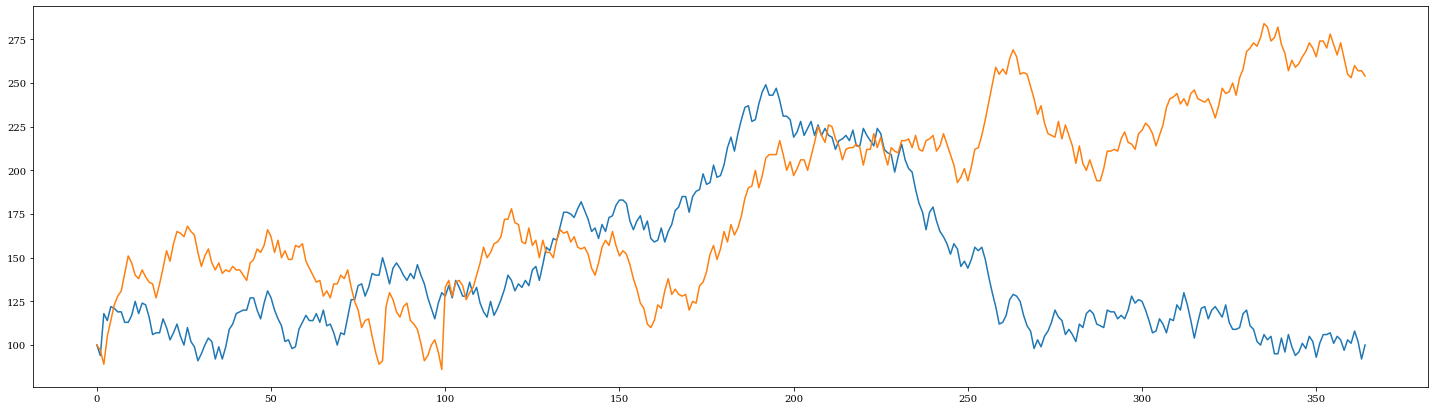

In [16]:
fig = plt.figure(figsize=(25,7))
plt.plot(df[df.DATAYear==2018]['zamowienia'].values)
plt.plot(df[df.DATAYear==2019]['zamowienia'].values)

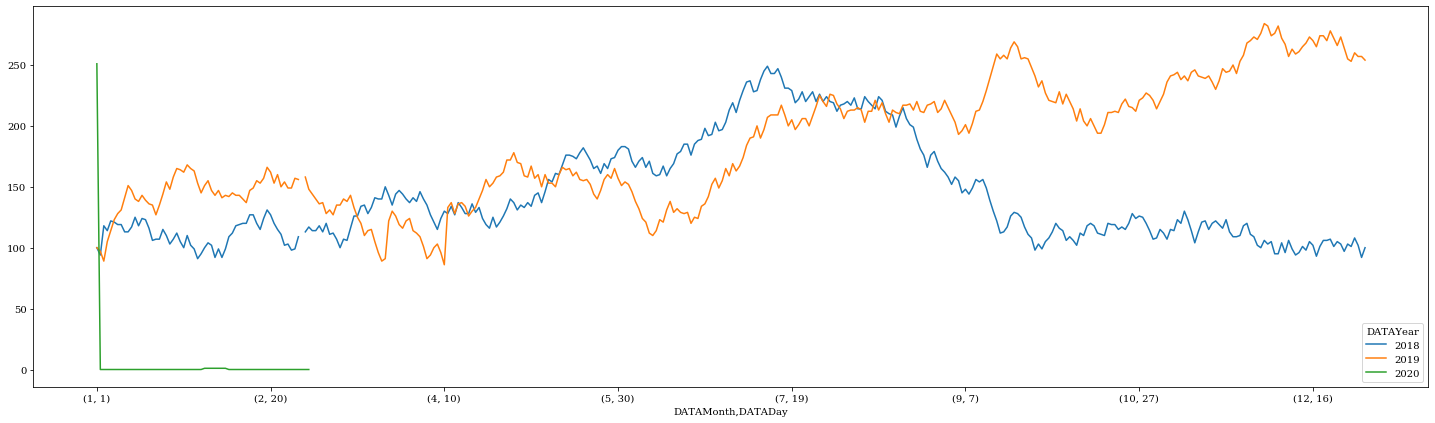

In [18]:
pv = pd.pivot_table(df, index=[df.DATAMonth, df.DATADay], columns=df.DATAYear,values='zamowienia', aggfunc='sum')
pv.plot(figsize=(25,7))
# pv = pd.pivot_table(df, index=df.DATAMonth, columns=df.DATAYear,values='wyprzedaż', aggfunc='sum')
# pv.plot(figsize=(25,7))

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [13]:
#DECISION TREE
X_train = df[['wyprzedaż','DATAMonth', 'DATAWeek', 'DATADay', 'DATADayofweek', 'DATADayofyear']][df.DATAYear==2018].values   
X_test = df[['wyprzedaż','DATAMonth', 'DATAWeek', 'DATADay', 'DATADayofweek', 'DATADayofyear']][df.DATAYear==2019].values
y_train =  df[['zamowienia']][df.DATAYear==2018].values
y_test =  df[['zamowienia']][df.DATAYear==2019].values

model = DecisionTreeRegressor(max_depth=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)

6282.689885066417

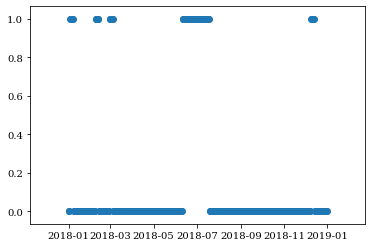

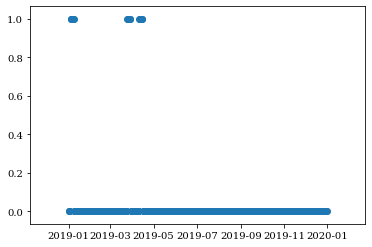

In [14]:
plt.scatter(df[['DATA']][df.DATAYear==2018].values, df[['wyprzedaż']][df.DATAYear==2018].values)
plt.show()
plt.scatter(df[['DATA']][df.DATAYear==2019].values, df[['wyprzedaż']][df.DATAYear==2019].values)

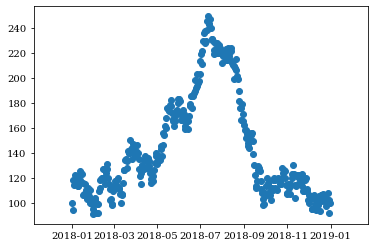

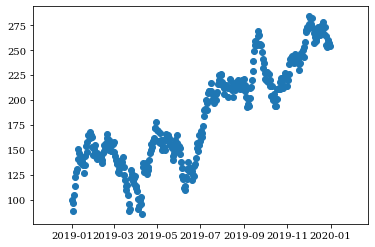

In [15]:
plt.scatter(df[['DATA']][df.DATAYear==2018].values, df[['zamowienia']][df.DATAYear==2018].values)
plt.show()
plt.scatter(df[['DATA']][df.DATAYear==2019].values, df[['zamowienia']][df.DATAYear==2019].values)

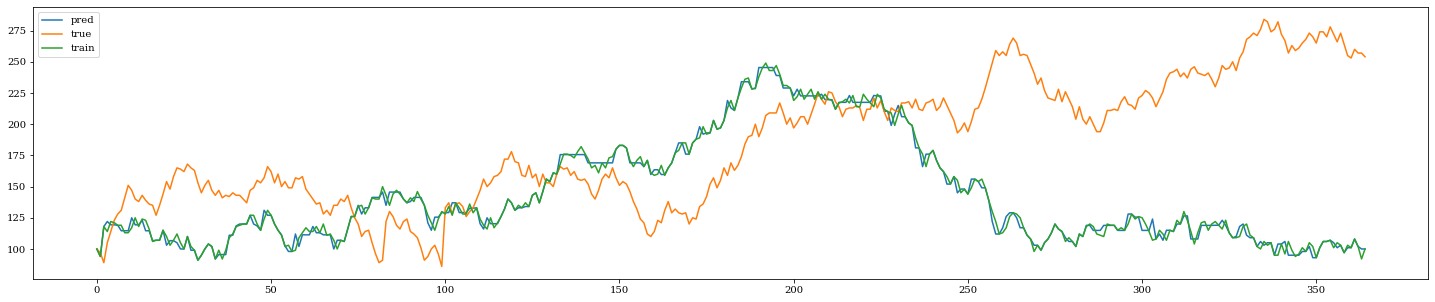

In [16]:
fig = plt.figure(figsize=(25,5))
plt.plot(y_pred)
plt.plot(y_test)
plt.plot(y_train)
plt.legend(['pred', 'true', 'train'])

In [17]:
model = RandomForestRegressor(max_depth=10, n_estimators=50, n_jobs=8) #n_estimators=50)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)# cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')

/home/marzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


6234.661234667126

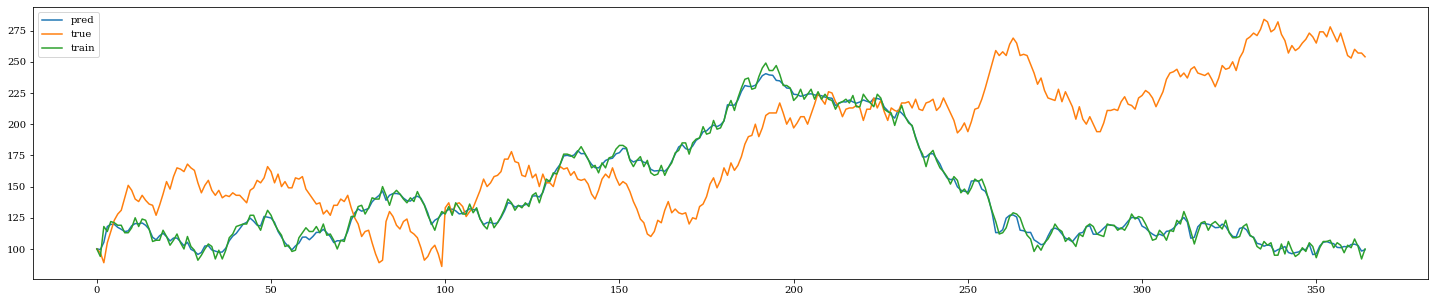

In [18]:
fig = plt.figure(figsize=(25,5))
plt.plot(y_pred)
plt.plot(y_test)
plt.plot(y_train)
plt.legend(['pred', 'true', 'train'])

In [19]:
# KERAS Regression
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [20]:
model = build_model()
model.fit(X_train, y_train, epochs=1000, verbose=0)

6465.500275584546


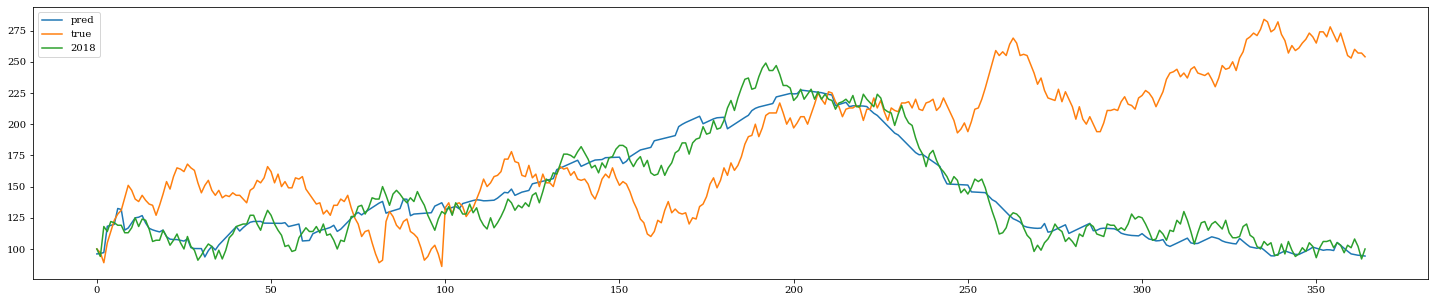

In [21]:
fig = plt.figure(figsize=(25,5))
# model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plt.plot(y_pred)
plt.plot(y_test)
plt.plot(y_train)
plt.legend(['pred', 'true', '2018'])
print(mean_squared_error(y_test, y_pred))

In [22]:
#ARIMA
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from datetime import datetime
import numpy as np
import matplotlib as mpl
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

/home/marzi/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


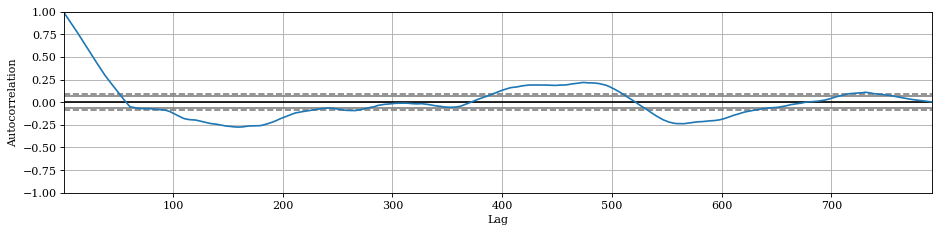

In [23]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(14,3), dpi= 80)
autocorrelation_plot(df[['zamowienia']])
plt.show() #

In [25]:
X_train = df[['DATA']][df.DATAYear==2018].values   
X_test = df[['DATA']][df.DATAYear==2019].values
y_train =  df[['zamowienia']][df.DATAYear==2018].values
y_test =  df[['zamowienia']][df.DATAYear==2019].values

In [74]:
df.head()

,DATA,zamowienia,wyprzedaż,DATAYear,DATAMonth,DATAWeek,DATADay,DATADayofweek,DATADayofyear,DATAIs_month_end,DATAIs_month_start,DATAIs_quarter_end,DATAIs_quarter_start,DATAIs_year_end,DATAIs_year_start,DATAElapsed
0,2018-01-01,100.0,0,2018,1,1,1,0,1,False,True,False,True,False,True,1514764800
1,2018-01-02,94.0,0,2018,1,1,2,1,2,False,False,False,False,False,False,1514851200
2,2018-01-03,118.0,1,2018,1,1,3,2,3,False,False,False,False,False,False,1514937600
3,2018-01-04,114.0,1,2018,1,1,4,3,4,False,False,False,False,False,False,1515024000
4,2018-01-05,122.0,1,2018,1,1,5,4,5,False,False,False,False,False,False,1515110400


p-value for train: 0.510275


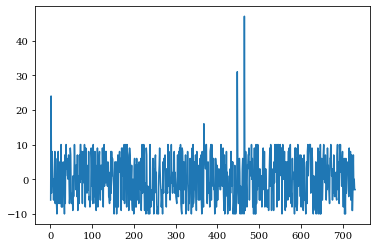

In [85]:
df['zamowienia_diff'] = df['zamowienia']  - df['zamowienia'] .shift(1)
df['zamowienia_diff'].dropna().plot()
result3 = adfuller( df['zamowienia'].dropna())
print('p-value for train: %f' % result3[1])

In [77]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

# result1 = adfuller(df['zamowienia'].values)
# print('ADF Statistic ALL: %f' % result1[0])
# print('p-value for whole process: %f' % result1[1])
result2 = adfuller( df['zamowienia'][df.DATAYear==2019])
print('p-value for test: %f' % result2[1]) 

result3 = adfuller( df['zamowienia'][df.DATAYear==2018])
print('p-value for train: %f' % result3[1])
#Proces NIEstacjonarny, d=0

p-value for test: 0.542770
p-value for train: 0.577881


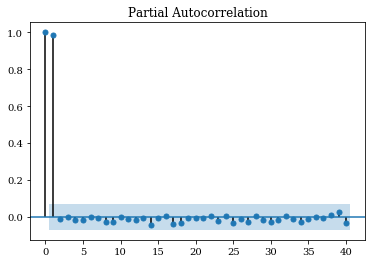

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(df["zamowienia"].dropna(), lags=40)
plt.show() #2 above

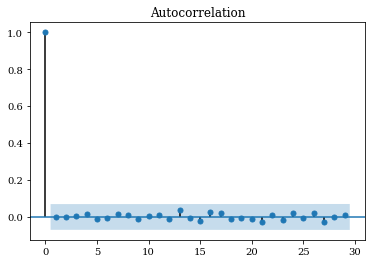

In [33]:
plot_acf(df["zamowienia"].diff().dropna())
plt.show() #3 above

In [34]:
history = [x for x in X_train]
predictions = []

def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat


for t in range(len(X_test)):
    model = ARIMA(history, order=(1, 1, 2)) #Determined by myself
    model_fit = model.fit(trend='nc', disp=False)
    ar_coef = model_fit.arparams
    yhat = predict(ar_coef, history)
    predictions.append(yhat)
    obs = X_test[t]
    history.append(obs)
    print('>predicted=%.3f, expected=%.3f' % (yhat, obs))

rmse = sqrt(mean_squared_error(X_test, predictions))
mse = (mean_squared_error(X_test, predictions))

print('Test RMSE: %.3f' % rmse)
print(mse)

/home/marzi/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:763: RuntimeWarning: divide by zero encountered in log
  return np.log(self.sigma2) + (1 + self.df_model) * np.log(nobs)/nobs


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

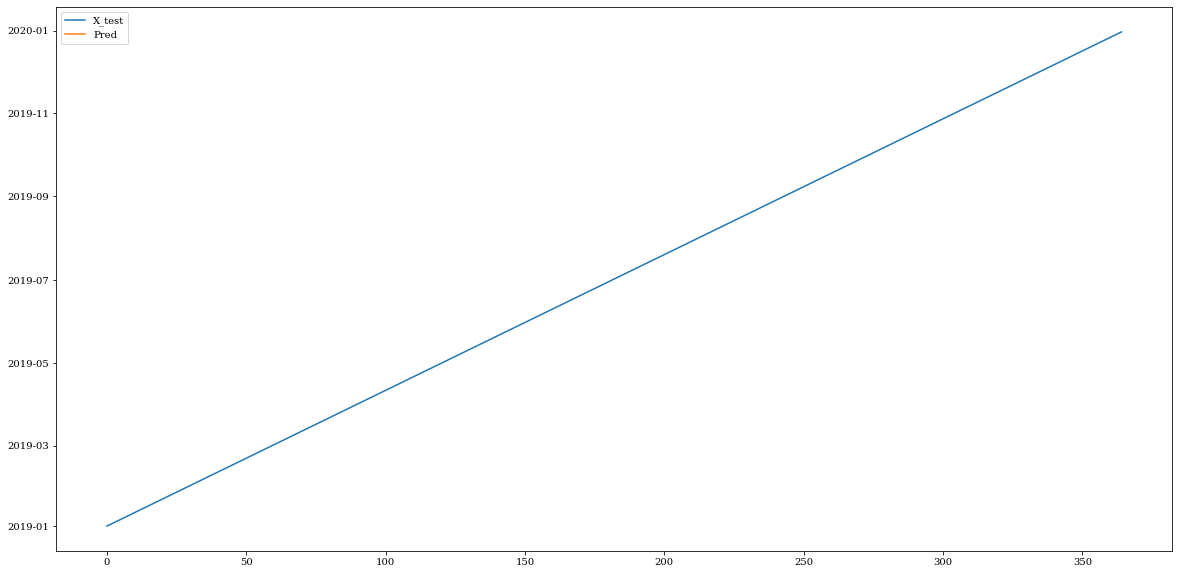

In [35]:
plt.figure(figsize=(20,10))

plt.plot(X_test)
plt.plot(predictions)
plt.legend(["X_test", "Pred"])

In [3]:
from fbprophet import Prophet
import pandas as pd
m = Prophet()
df = pd.read_csv("predykcja.csv", sep=';')
df = df[-df.DATA.isna()]
df.DATA = pd.to_datetime(df['DATA'], format="%d.%m.%Y")
df.wyprzedaż = df.wyprzedaż.fillna(0).astype(int)
df = df.iloc[:, 0:2]
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2018-01-01,100.0
1,2018-01-02,94.0
2,2018-01-03,118.0
3,2018-01-04,114.0
4,2018-01-05,122.0


In [4]:
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [5]:
future = m.make_future_dataframe(periods=62) #62
future.tail()

,ds
788,2020-02-28
789,2020-02-29
790,2020-03-01
791,2020-03-02
792,2020-03-03


In [6]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
788,2020-02-28,380.714236,362.138994,399.408219
789,2020-02-29,380.452386,362.954779,400.366989
790,2020-03-01,380.934008,359.833864,401.191748
791,2020-03-02,380.780754,361.966899,400.958898
792,2020-03-03,380.980712,359.312181,400.070669


In [12]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,102.730833,58.007847,93.688420,102.730833,102.730833,-27.650247,-27.650247,-27.650247,-0.064985,-0.064985,-0.064985,-27.585262,-27.585262,-27.585262,0.0,0.0,0.0,75.080587
1,2018-01-02,103.105089,60.992385,97.246644,103.105089,103.105089,-24.213211,-24.213211,-24.213211,0.133525,0.133525,0.133525,-24.346736,-24.346736,-24.346736,0.0,0.0,0.0,78.891878
2,2018-01-03,103.479345,63.368881,101.145320,103.479345,103.479345,-20.930485,-20.930485,-20.930485,0.131361,0.131361,0.131361,-21.061845,-21.061845,-21.061845,0.0,0.0,0.0,82.548860
3,2018-01-04,103.853600,67.924464,103.487801,103.853600,103.853600,-17.450636,-17.450636,-17.450636,0.329709,0.329709,0.329709,-17.780345,-17.780345,-17.780345,0.0,0.0,0.0,86.402964
4,2018-01-05,104.227856,72.179878,107.395232,104.227856,104.227856,-14.719769,-14.719769,-14.719769,-0.168455,-0.168455,-0.168455,-14.551314,-14.551314,-14.551314,0.0,0.0,0.0,89.508087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,2020-02-28,381.582750,362.138994,399.408219,375.945636,386.526673,-0.868514,-0.868514,-0.868514,-0.168455,-0.168455,-0.168455,-0.700059,-0.700059,-0.700059,0.0,0.0,0.0,380.714236
789,2020-02-29,382.601430,362.954779,400.366989,376.822958,387.680774,-2.149043,-2.149043,-2.149043,-0.430918,-0.430918,-0.430918,-1.718126,-1.718126,-1.718126,0.0,0.0,0.0,380.452386
790,2020-03-01,383.620110,359.833864,401.191748,377.720658,388.841384,-2.686102,-2.686102,-2.686102,0.069763,0.069763,0.069763,-2.755865,-2.755865,-2.755865,0.0,0.0,0.0,380.934008
791,2020-03-02,384.638789,361.966899,400.958898,378.589586,389.988637,-3.858035,-3.858035,-3.858035,-0.064985,-0.064985,-0.064985,-3.793050,-3.793050,-3.793050,0.0,0.0,0.0,380.780754


/home/marzi/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/marzi/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


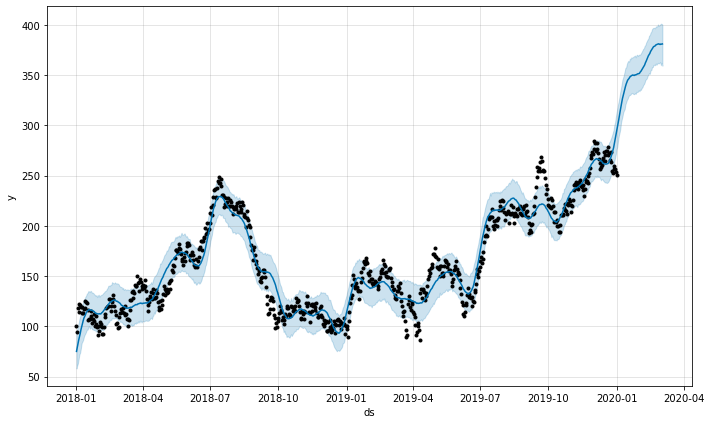

In [7]:
fig1 = m.plot(forecast)

/home/marzi/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/marzi/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/marzi/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/marzi/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`)

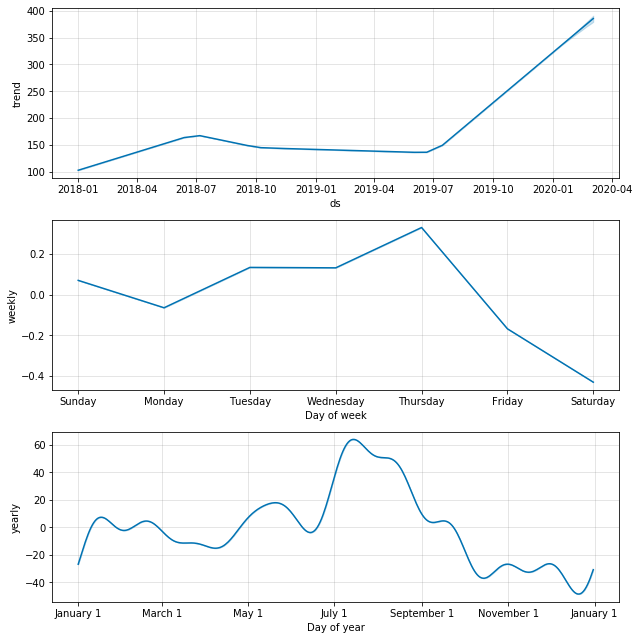

In [8]:
fig2 = m.plot_components(forecast)

In [9]:
forecast[(forecast.ds > '2020-01-01') & (forecast.ds < '2020-02-01')]['yhat'].sum()

10107.071808948871

In [10]:
forecast[(forecast.ds > '2020-01-31') & (forecast.ds < '2020-03-01')]['yhat'].sum()

10717.833669579986

In [ ]:
#Model addytywny 
#Suma styczeń ~10107.072
#Suma luty ~10717.83
#Podjęte kroki: 
#wybrany model

In [20]:
from sklearn import tree
from sklearn.datasets import load_iris

[Text(167.4, 163.07999999999998, 'X[0] <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(83.7, 54.360000000000014, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]')]

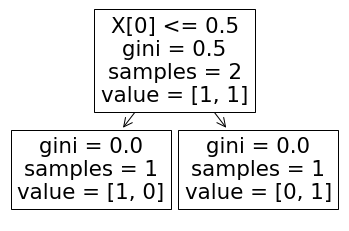

In [21]:
X = [[0,0], [1,1]]
y = [0,1]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X,y)
tree.plot_tree(clf.fit(X,y))

[Text(558.0, 597.96, 'X[3] <= 0.8\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(472.15384615384613, 489.24, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(643.8461538461538, 489.24, 'X[3] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(343.38461538461536, 380.52000000000004, 'X[2] <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(171.69230769230768, 271.8, 'X[3] <= 1.65\ngini = 0.041\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(85.84615384615384, 163.07999999999998, 'gini = 0.0\nsamples = 47\nvalue = [0, 47, 0]'),
 Text(257.53846153846155, 163.07999999999998, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(515.0769230769231, 271.8, 'X[3] <= 1.55\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(429.23076923076917, 163.07999999999998, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(600.9230769230769, 163.07999999999998, 'X[2] <= 5.45\ngini = 0.444\nsamples = 3\nvalue = [0, 2, 1]'),
 Text(515.0769230769231, 54.36000000000

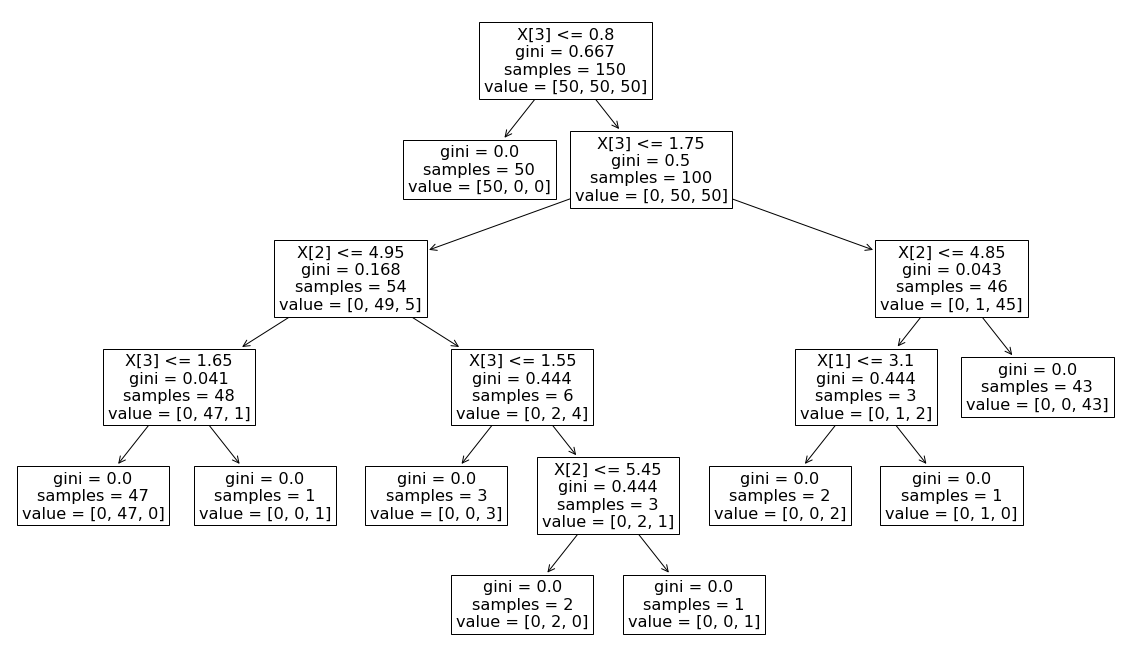

In [22]:
df = load_iris()
X = df['data']
y = df['target']
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X,y)
fig, ax = plt.subplots(figsize=(20, 12))
tree.plot_tree(clf.fit(X,y))

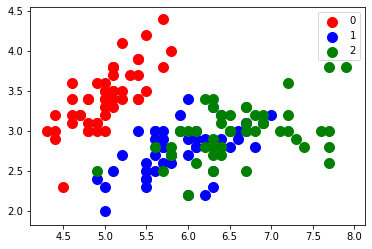

In [23]:
scatter_x = X[:,0:1]
scatter_y = X[:,1:2]
group = y
cdict = {0: 'red', 1: 'blue', 2: 'green'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)
ax.legend()
plt.show()

In [31]:
np.c_[xx.ravel(), yy.ravel()]

array([[3.3 , 1.  ],
       [3.32, 1.  ],
       [3.34, 1.  ],
       ...,
       [8.84, 5.38],
       [8.86, 5.38],
       [8.88, 5.38]])

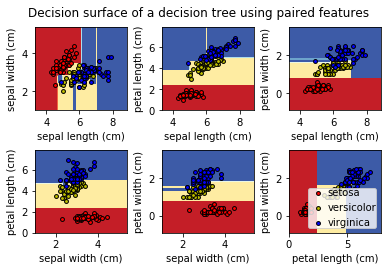

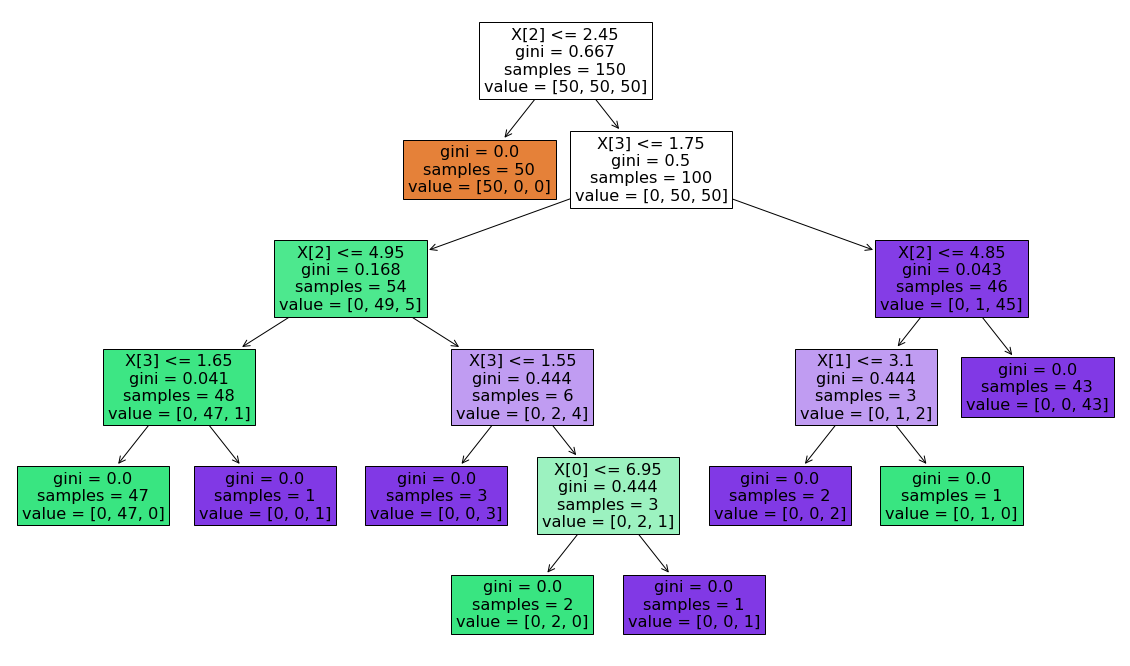

In [27]:
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

# Load data
iris = load_iris()

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3],]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = tree.DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

fig, ax = plt.subplots(figsize=(20, 12))
clf = tree.DecisionTreeClassifier().fit(iris.data, iris.target)
tree.plot_tree(clf, filled=True)
plt.show()